<a href="https://colab.research.google.com/github/winneking/hello-world/blob/master/augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import cv2
import os
import math
import h5py as h5py


In [19]:
!apt-get -qq install -y graphviz && pip install -q pydot
import pydot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from IPython.display import Image

from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input,Dense,Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

RATIO = 0.2

NUM_DENSE = 5

epochs = 1

ishape=48

def tran_y(y):
    y_ohe = np.zeros(NUM_DENSE)
    y_ohe[y] = 1
    return y_ohe
  
print('download vgg Model')

model_vgg = VGG16(include_top = False, weights = 'imagenet',input_shape = (ishape,ishape, 3))

for layer in model_vgg.layers:
          layer.trainable = False
model = Flatten()(model_vgg.output)
model = Dense(4096, activation='relu',name='fc1')(model)
model = Dense(4096, activation='relu',name='fc2')(model)
model = Dropout(0.5)(model)
model = Dense(NUM_DENSE,activation = 'softmax', name= 'prediction')(model)
model_vgg_pretrain = Model(model_vgg.input, model, name = 'vgg16_pretrain')

print('Model compile')

sgd = SGD(lr = 0.05, decay = 1e-5)
model_vgg_pretrain.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])


download vgg Model
Model compile


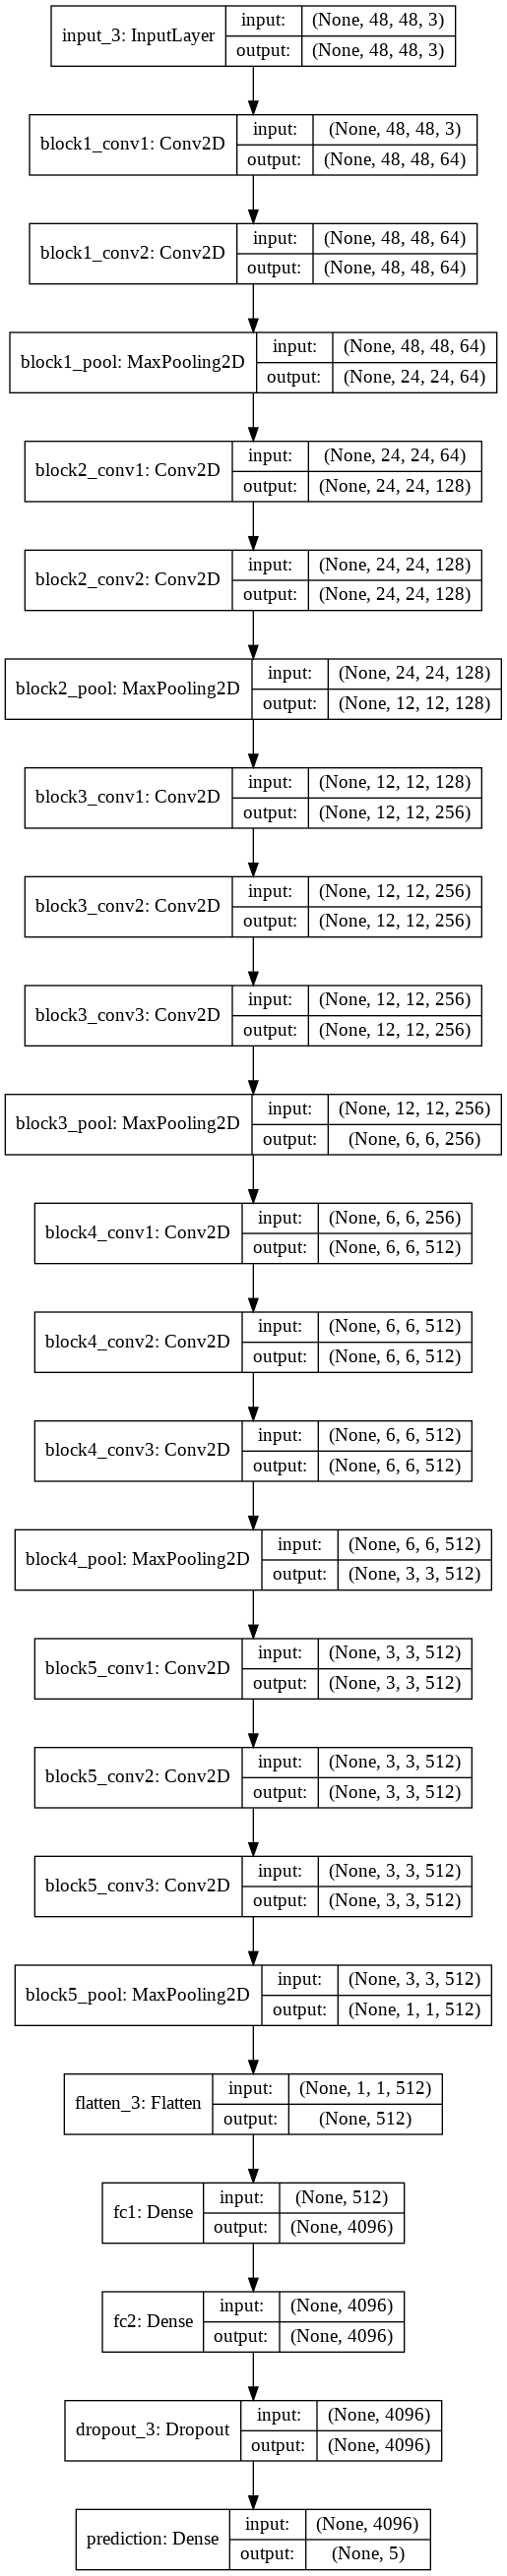

In [20]:
plot_model(model_vgg_pretrain, to_file="model.png", show_shapes=True)
Image('model.png')

In [21]:
print('download Data')

path='littleCBIR_none.npz'
path = get_file(path,origin='https://github.com/jsxyhelu/DateSets/raw/master/littleCBIR_none.npz')
f = np.load(path)
X_train,y_train = f['X_train'], f['y_train']
X_test,y_test = f['X_test'], f['y_test']

X_train = [cv2.cvtColor(cv2.resize(i, (ishape,ishape)), cv2.COLOR_GRAY2BGR) for i in X_train]
X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')
X_train /= 255.0

X_test = [cv2.cvtColor(cv2.resize(i, (ishape,ishape)), cv2.COLOR_GRAY2BGR) for i in X_test]
X_test= np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')
X_test /= 255.0

y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])
y_train_ohe = y_train_ohe.astype('float32')
y_test_ohe = y_test_ohe.astype('float32')


#agumentation
#Set building parameters
img_generator = ImageDataGenerator(
            featurewise_center=False, # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False, # divide inputs by std of the dataset
            samplewise_std_normalization=False, #divide each input by its std
            zca_whitening=False, # apply ZCA whitening
            rotation_range=0,     # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1, #randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1, #randomly shift images vertically (fraction of total height)
            horizontal_flip=True, # randomly flip images
            vertical_flip=False) #randomly flip images

print('Training Model')
#Training Model
#TODOsteps_per_epoch =400
img_generator.fit(X_train)
log = model_vgg_pretrain.fit_generator(img_generator.flow(X_train,batch_size=128),steps_per_epoch=10,
                                      epochs=epochs,validation_data=(X_test,y_test_ohe),workers=4)
score = model_vgg_pretrain.evaluate(X-test,y_test-ohe,verbose=0)

#Display Print Result
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Plot loss and accc curve
plt.figure('acc')
plt.subplot(2,1,1)
plt.plot(log.history['acc'],'r--',laber='Training Accuracy')
plt.plot(log.history['val_acc'],'r--',label='Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.axis([0,epochs,0.9,1])
plt.figure('loss')
plt.subplot(2,1,2)
plt.plot(log.history['loss'],'b--',label='Training Loss')
plt.plot(log,history['val_losss'],'b-',label='Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.axis([0,epochs,0,1])
plt.show()

model_vgg_pretrain.save('5type4cbirMODEL.h5')

download Data
Training Model
Epoch 1/1


ValueError: ignored